In [144]:
import astropy
from astropy.io import fits
from astropy.io import ascii
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import odr
from matplotlib.pyplot import figure
import matplotlib.colors as mcolors

In [145]:
#APOKASC file & file variables
hdul = fits.open(r"/Users/amber3/Desktop/SSI/APOKASC_cat_v6.7.2.fits")
hdu = hdul[1]
A_data = hdu.data
#print(np.size(A_data))
KIC_A = hdu.data['KEPLER_INT'] 
Logg_A = hdu.data['DR16_LOGG_COR']
Teff_A = hdu.data['DR16_TEFF_COR']
FeH_A = hdu.data['DR16_M_H_COR']
R_APO3 = hdu.data['APOKASC3P_RADIUS']

In [146]:
#GAIA file variables
#there are some empty entries in error and radius, so flags are put in as -42 and only pos entries are taken
G_data = ascii.read('/Users/amber3/Desktop/gaia_radii_apokasc3 .dat', delimiter = ',') #data_Splitter = 'KIC') #fill_values = [('-42.0', '', '-42.0')])
KIC_G = G_data['KIC']
R_G = 1.0/G_data['inv_r_gaia_K_MIST']
R_G_err_per = G_data['inv_r_gaia_K_MIST_err']/G_data['inv_r_gaia_K_MIST'] 
R_G_err = R_G_err_per * R_G

In [147]:
#APOLLINAIRE file & file variables (b = background)
hdul_b = fits.open(r"/Users/amber3/Desktop/SSI/Selected_stars_final.fits")
hdu_b = hdul_b[0]
B_data = hdu_b.data
KIC_B = np.array(B_data[:,0,0])

In [148]:
#Intersection between Apollinaire and APOKASC
common_KIC, A_indices, B_indices = np.intersect1d(KIC_A, KIC_B, return_indices=True)

good_indices = np.where((Teff_A[A_indices] > 0) & (R_APO3[A_indices] > 0))
bad_indices = np.where(np.logical_or(Teff_A[A_indices] <= 0, R_APO3[A_indices] <= 0))

B_indices = B_indices[good_indices]
A_indices = A_indices[good_indices]

A_data = A_data[A_indices]
B_data = np.array(B_data[B_indices,:,:])

KIC_B = np.array(B_data[:,0,0])

In [149]:
#intersection between Gaia and (Apollinaire & Apokasc)
common_KIC_G, G_indices, AB_indices = np.intersect1d(KIC_G, KIC_B, return_indices=True)
good_indices = np.where((R_G[G_indices] > 0) & (R_G_err[G_indices] > 0))
G_indices = G_indices[good_indices]
AB_indices = AB_indices[good_indices]

G_data = G_data[G_indices]
A_data = A_data[AB_indices]
B_data = B_data[AB_indices]
KIC_B = KIC_B[AB_indices]

In [150]:
#Raw data Variables
ln10 = np.log(10)
Teff = A_data['DR16_TEFF_COR']
logTeff = np.log10(Teff)
elogTeff = A_data['DR16_TEFF_COR_ERR']/Teff/ln10
logg = A_data['DR16_LOGG_COR']
elogg = A_data['DR16_LOGG_COR_ERR']
FeH = A_data['DR16_M_H_COR']
eFeH = A_data['Dr16_M_H_COR_ERR']
logAmp1 = np.log10(B_data[:,0,6])
elogAmp1 = B_data[:,1,6]/B_data[:,0,6]/ln10
logAmp2 = np.log10(B_data[:,0,9])
elogAmp2 = B_data[:,1,9]/B_data[:,0,9]/ln10
logFreq1 = np.log10(B_data[:,0,7])
elogFreq1 = B_data[:,1,7]/B_data[:,0,7]/ln10
logFreq2 = np.log10(B_data[:,0,10])
elogFreq2 = B_data[:,1,10]/B_data[:,0,10]/ln10
Evolstage = B_data[:,0,3]
itemp = np.where(Evolstage == 1)
iRG = np.reshape(itemp, np.size(itemp))
itemp = np.where(Evolstage == 2)
iRC = np.reshape(itemp, np.size(itemp))
logR_G = -np.log10(G_data['inv_r_gaia_K_MIST'])
elogR_G = G_data['inv_r_gaia_K_MIST_err']/G_data['inv_r_gaia_K_MIST']/ln10
logR_A = A_data['APOKASC3P_RADIUS'] #check
elogR_A = A_data['APOKASC3P_RADIUS_ERR'] #check
rpw = 2

In [151]:
def linear_fit(X,a,b,c,d):
    x,y,z = X
    return a+b*x+c*y+z*d

In [152]:
#General function for orthogonal fitting of amps and freqs
def odr_fit(A, X):
    x,y,z = X
    return A[0]+A[1]*x+A[2]*y+A[3]*z

In [153]:
def orth_fittings(x,sx,y,sy):
    c_data = odr.RealData(x, y, sx=sx, sy=sy)
    linear = odr.Model(odr_fit)
    beta0 = [183.7, -48.0, -0.73, -0.52] #softcode first linear guesses based j in loop
    c_odr = odr.ODR(c_data, linear, beta0=beta0)
    c_output = c_odr.run()
    #c_output.pprint()
    print(c_output.beta)
    print(c_output.sd_beta)
    return c_output

In [154]:
#coeffs and errors are 4x2x4 arrays (input)
def plottings(coeffs,errors):
    Ncoeff = np.shape(coeffs) #4x2x4
    %matplotlib inline
    figure(figsize=(8,8), dpi=100)
    minimum = np.amin(coeffs-errors)
    maximum = np.amax(coeffs+errors)
    margin = (maximum - minimum)*0.03
    x = [0, 1, 2, 3]
    #coeffs = np.ones([4,6,2])
    #ecoeffs = np.ones([4,6,2])
    xl = 0.70
    dxl = 0.15
#arrays of lines so it depends on dimensions of coeffs ? look for next time
#IDEAS: there's update_datalim or just initialize array and specify data[] to add in handles
    labels = ['A1', 'f1', 'A2', 'f2']
    style = ['solid', 'dashed']
    titl = ['red giants', 'red clump']
    color = ['black', 'green', 'purple', 'blue']
    line = [] #'matplotlib.container.ErrorbarContainer']
    #Leg = []
    for j in range(0,Ncoeff[1]): #(only using r corrected amps), j is rgb=0 or redclump=1
        for k in range(0,Ncoeff[2]): #k is Harvey params of two components. 0=A1, 1=f1, 2=A2, 3=f2
            lin1 = plt.errorbar(x, coeffs[:,j,k], yerr = errors[:,j,k], capsize = 4, linestyle = style[j], label = labels[k], color=color[k])
            line.append(lin1)
            
            if j == 0 and k == 0:
                #line = np.asarray(lin1, dtype=None, order=None, like=None)
                print('first:',j,k, np.shape(line))
            else:
                #np.append(line, [lin1]) #dtype = 'matplotlib.container.ErrorbarContainer')
                print('later:',j,k, np.shape(line))
            #print(np.dtype('matplotlib.container.ErrorbarContainer'))
            #print(type(lin1), np.shape(lin1))
            #print(lin1.dtype)
            #line = [[line], lin1]
            #np.append(line, plt.errorbar(x, coeffs[:,j,k], yerr = errors[:,j,k], capsize = 4, linestyle = style[j], label = labels))
        leg = plt.legend(handles=line[j*4:(j+1)*4],title = titl[j], loc = (xl+dxl*j,0.8))
        plt.gca().add_artist(leg)
    #print(np.shape(line))
    #print(type(line), np.size(line), np.shape(line))
    #Line = np.reshape(line, [2,4,3])
    #print(type(Line[1,1,:]), np.shape(Line))
    #for j in range(0,Ncoeff[1]):
        #leg = plt.legend(handles=line[j*4:(j+1)*4-1,:], title = titl[j], loc = (xl,0.1))
    #c
    #plt.gca().add_artist(leg)
    #leg = plt.legend(handles=[line[1]], title = titl[0], loc = (xl+dxl,0.9))
    #plt.gca().add_artist(leg)
    #plt.legend()
    
        #Leg.append(leg)
    #plt.ylim(minimum - margin, maximum + margin)
    #plt.ylim()
    plt.xticks([0, 1, 2, 3], ['const', 'log(Teff)', 'logg', '[Fe/H]'])
    plt.ylabel('Fitting Coefficients')
    plt.show()
    return line
    
        #else: 
            #line[j,k] = plt.errorbar(x, np.reshape(coeffs[]), yerr = np.reshape(), capsize = 4, linestyle = 'dashed', label = labels)
            #leg_giant = plt.legend(handles=[line], title = 'red clump', loc = (xl,0.1))
            #plt.gca().add_artist(leg_giant)
    

In [155]:
NH = 4 #number of Harvery comps
Nj = 4 #j samples of stars: either all red giants, all red clump, subsamples, etc
Np = 3 + 1 #number of atm params plus offset
c = np.ndarray((NH,Nj,Np), dtype=float)
e = np.ndarray((NH,Nj,Np), dtype=float)

for j in (0,1,2,3):
    if j < 4:
        #Use Gaia Radii
        logAmp1_R = logAmp1 + rpw * logR_G 
        elogAmp1_R = np.sqrt(elogAmp1**2 + (rpw*elogR_G)**2)
    else:
        #Use APO3 Radii
        logAmp1_R = logAmp1 + rpw * logR_A #change tp APO3 Radii variables
        elogAmp1_R = np.sqrt(elogAmp1**2 + (rpw*elogR_A)**2)
    if j == 0: #all red giants
        ii = iRG
        print('Giants_Gaia')
    elif j == 1: #all red clump
        ii = iRC
        print('Red_Clump_Gaia')
    elif j == 2: #matched subsample giants
        eps = 0.02 #comes from the sorted total differences between atm parameters. Picked as a good threshold to get max paired stars in similar magnitude.
        ii = ()
        iRCs = ()
        dists = ()
        for i in range(0, np.size(iRC)):
            dist2 = (logTeff[iRG]-logTeff[iRC[i]])**2 + ((logg[iRG]-logg[iRC[i]])/3.0)**2 + ((FeH[iRG]-FeH[iRC[i]])/0.8)**2
            dist = np.sqrt(dist2)
            min_dist = (np.min(dist))
            if min_dist < eps:
                index = np.where(dist == min_dist)
                ii = ii + (index[0],)
                iRCs = iRCs + (i,)
                dists = dists + (min_dist,)
        iu = np.unique(ii, return_index=True) #indices of unique elements in red giants
        iu = np.array(iu)[1,:]
        
        Nii = len(ii)
        ii = np.reshape(ii, (Nii,))
        iRCs = np.reshape(iRCs, (Nii,))
        dists = np.reshape(dists, (Nii,))
        
        ii = iRG[ii[iu]]
        iRCs = iRC[iRCs[iu]]
        iRGs = ii
        dists = dists[iu]
        Niu = np.size(iu) #52 
                
        print('Matched RG sample:', np.size(iRCs))
    elif j== 3: #matched subsample clump 
        ii = iRCs
        print('Matched RC sample:', np.size(iRCs))
        #52 matched pairs
    else:
        print('how did we get here??')
    
    x = [logTeff[ii], logg[ii], FeH[ii]]
    sx = [elogTeff[ii], elogg[ii], eFeH[ii]]
    
    y = [logAmp1[ii]]
    sy = [elogAmp1[ii]]
    print('A1_fit:')
    A1_fit = orth_fittings(x,sx,y,sy)
    c[:,j,0] = A1_fit.beta
    e[:,j,0] = A1_fit.sd_beta
    
    y = [logFreq1[ii]]
    sy = [elogFreq1[ii]]
    print('f1_fit:')
    f1_fit = orth_fittings(x,sx,y,sy)
    c[:,j,1] = f1_fit.beta
    e[:,j,1] = f1_fit.sd_beta
    
    y = [logAmp2[ii]]
    sy = [elogAmp2[ii]]
    print('A2_fit:')
    A2_fit = orth_fittings(x,sx,y,sy)
    c[:,j,2] = A2_fit.beta
    e[:,j,2] = A2_fit.sd_beta
    
    y = [logFreq2[ii]]
    sy = [elogFreq2[ii]]
    print('f2_fit:')
    f2_fit = orth_fittings(x,sx,y,sy)
    c[:,j,3] = f2_fit.beta
    e[:,j,3] = f2_fit.sd_beta
    

Giants_Gaia
A1_fit:
[ 369.95964338 -101.55594751    2.53099205   -1.95686022]
[31.82572343  8.95477346  0.39987056  0.19071475]
f1_fit:
[ 648.40179735 -182.78328117    9.01718293   -3.81443906]
[234.61005664  66.0284419    2.95470176   1.36637274]
A2_fit:
[ 473.39099771 -130.75651543    3.70859076   -2.56825606]
[48.4319332  13.62778363  0.6083334   0.28769483]
f2_fit:
[ 540.59767091 -152.32244583    7.68572835   -3.19539174]
[154.02914558  43.35017443   1.94078938   0.89881977]
Red_Clump_Gaia
A1_fit:
[182.67908575 -49.40432938   1.33364213  -1.98953653]
[5.7074864  1.61723171 0.11446275 0.06645245]
f1_fit:
[-92.5283185   26.1938668   -1.15668919   1.09529983]
[4.6920561  1.33168799 0.09147027 0.05402167]
A2_fit:
[208.29619082 -56.78685999   1.70215799  -2.40282688]
[7.15555207 2.02813983 0.14247318 0.08307806]
f2_fit:
[-67.35486573  19.11958133  -0.5998097    0.8154046 ]
[2.43568516 0.69041684 0.04846145 0.02827013]
Matched RG sample: 219
A1_fit:
[236.92000497 -64.20393031   1.0540749

closest KICs in Teff/logg: RGs, RCs


IndexError: index 2888 is out of bounds for axis 0 with size 219

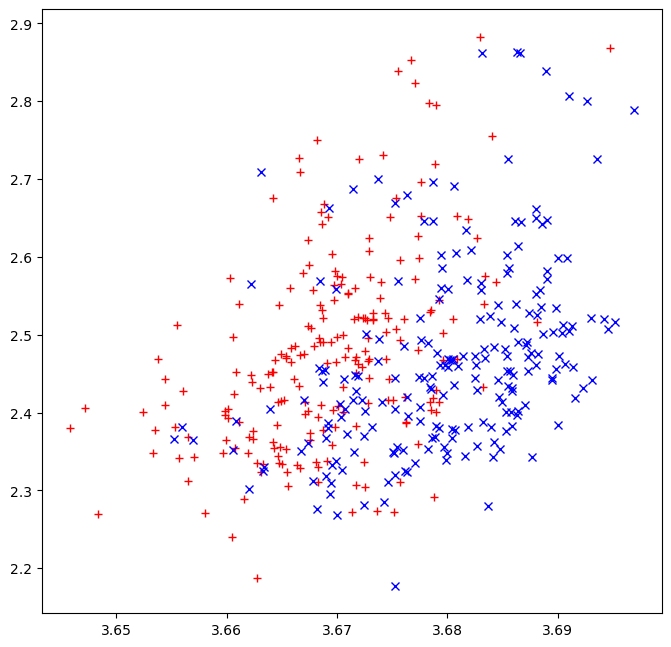

In [168]:
#print(dists[inds])
#print(np.shape(inds), np.size(inds))

figure(figsize=(8,8), dpi=100)
plt.plot(logTeff[iRGs], logg[iRGs], 'r+')
plt.plot(logTeff[iRCs], logg[iRCs], 'bx')

list1 = np.array(np.log10(logAmp1[iRGs]))
list2 = np.array(np.log10(logFreq1[iRGs]))

list3 = np.array(np.log10(logAmp1[iRCs]))
list4 = np.array(np.log10(logFreq1[iRCs]))

set_diff = np.sqrt((list1 - list3)**2 + (list2 - list4)**2)
list_diff = np.array(set_diff)

inds = np.argsort(dists)

#indse = np.argsort(list_diff)

print('closest KICs in Teff/logg: RGs, RCs')
print(KIC_B[iRGs[inds[0:5]]], KIC_B[iRCs[inds[0:5]]], list_diff[iRCs[inds[0:5]]])
print()
print('furthest KICS in Teff/logg: RGs, RCs')
print(KIC_B[iRGs[inds[Niu-5:Niu]]], KIC_B[iRCs[inds[Niu-5:Niu]]], list_diff[iRCs[inds[Niu-5:Niu]]])

plt.plot(logTeff[iRGs[inds[0:5]]], logg[iRGs[inds[0:5]]], 'k+', markersize=12)
plt.plot(logTeff[iRCs[inds[0:5]]], logg[iRCs[inds[0:5]]], 'kx', markersize=12)
#plot_colortable(mcolors.CSS4_COLORS, "")
plt.plot(logTeff[iRGs[inds[Niu-5:Niu]]], logg[iRGs[inds[Niu-5:Niu]]], color='orange', marker='+', linestyle='none', markersize=12)
plt.plot(logTeff[iRCs[inds[Niu-5:Niu]]], logg[iRCs[inds[Niu-5:Niu]]], color='orange', marker='x', linestyle='none', markersize=12)

(4, 4, 4) (4, 4, 4)
[[[ 3.69959643e+02  6.48401797e+02  4.73390998e+02  5.40597671e+02]
  [ 1.82679086e+02 -9.25283185e+01  2.08296191e+02 -6.73548657e+01]
  [ 2.36920005e+02 -1.69492935e+02  2.70145264e+02 -1.39151659e+02]
  [ 1.50160350e+02 -6.39613162e+01  1.60897106e+02 -5.53963171e+01]]

 [[-1.01555948e+02 -1.82783281e+02 -1.30756515e+02 -1.52322446e+02]
  [-4.94043294e+01  2.61938668e+01 -5.67868600e+01  1.91195813e+01]
  [-6.42039303e+01  4.74554676e+01 -7.36620490e+01  3.90445221e+01]
  [-4.00873381e+01  1.80044594e+01 -4.32070266e+01  1.56635190e+01]]

 [[ 2.53099205e+00  9.01718293e+00  3.70859076e+00  7.68572835e+00]
  [ 1.33364213e+00 -1.15668919e+00  1.70215799e+00 -5.99809704e-01]
  [ 1.05407491e+00 -1.41294454e+00  1.37987261e+00 -1.00246013e+00]
  [ 5.90845873e-01 -5.07327270e-01  6.28348176e-01 -2.82280292e-01]]

 [[-1.95686022e+00 -3.81443906e+00 -2.56825606e+00 -3.19539174e+00]
  [-1.98953653e+00  1.09529983e+00 -2.40282688e+00  8.15404604e-01]
  [-1.72116065e+00  1.

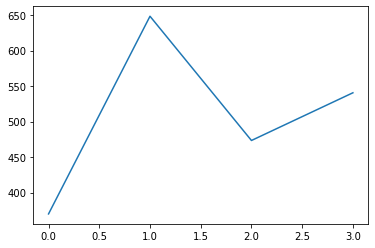

first: 0 0 (1, 3)
later: 0 1 (2, 3)
later: 0 2 (3, 3)
later: 0 3 (4, 3)
later: 1 0 (5, 3)
later: 1 1 (6, 3)
later: 1 2 (7, 3)
later: 1 3 (8, 3)


/Users/amber3/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/amber3/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/amber3/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tu

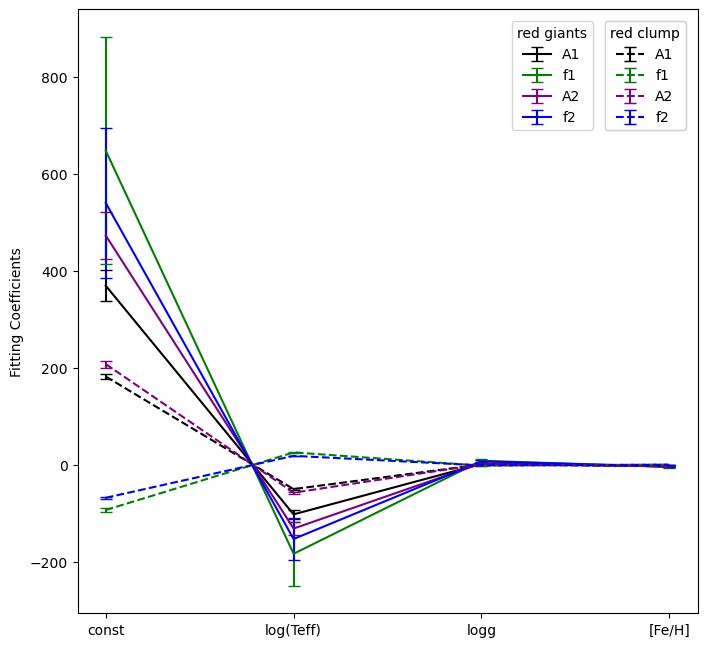

In [157]:
#call plottings with 4 subplots here 
#reshape arrays here
#two plots with whole sample, Gaia and APO3
#two plots with subsample, Gaia and APO3
#choose which radius we're using for each plot here?
#add titles here also
#add overplotting variable so we can change between two different radii, or full and matched subsamples, etc

print(np.shape(c),np.shape(e))
print(c)
plt.plot(c[0,0,:])
plt.show()
line = plottings(c[:,0:2,:],e[:,0:2,:]) #4x2x4 array input

In [158]:
#SMALLEST AND LARGEST DIFFS BETWEEN AMP 1 and F1 with respect to each other(Teff, logg)

#list1 = np.array(np.log10(Amp_HV1_RG[index_RG])) 
#list2 = np.array(np.log10(F_HV1_RG[index_RG]))
#list2 = np.array((log_Teff_final_RG[index_RG], logg_final_RG[index_RG], FeH_final_RG[index_RG]))

#list3 = np.array(np.log10(Amp_HV1_RC[index_RC])) 
#list4 = np.array(np.log10(F_HV1_RC[index_RG]))
#list4 = np.array((log_Teff_final_RC[index_RC], logg_final_RC[index_RC], FeH_final_RC[index_RC]))

#set_diff = np.sqrt((list1 - list3)**2 + (list2 - list4)**2)f
#list_diff = np.array(set_diff)

#smallest difference bewtween the two
#inds = np.argsort(list_diff)
#print(np.size(inds))
      
#figure(figsize=(8,8), dpi=100)
#plt.plot(log_Teff_final_RG[index_RG], logg_final_RG[index_RG],'r.')
#plt.plot(log_Teff_final_RC[index_RC], logg_final_RC[index_RC],'b.')
#plt.plot(log_Teff_final_RG[index_RG[inds[0:10]]], logg_final_RG[index_RG[inds[0:10]]],'kx', markersize=12)
#plt.show()

#for i in range(0,5):
#    print(KIC_final[index_RC[inds[i]]], KIC_final[index_RG[inds[i]]], list_diff[inds[i]])

#print()
#for i in range(50,55):
#    print(KIC_final[index_RC[inds[i]]], KIC_final[index_RG[inds[i]]], list_diff[inds[i]])

In [15]:
#for i in range(0, N_RC): 
#    dist = np.sqrt((7*(log_Teff_final_RG-log_Teff_final_RC[i]))**2 + (logg_final_RG-logg_final_RC[i])**2 + (3*(FeH_final_RG-FeH_final_RC[i]))**2)
#    min_dist = (np.min(dist)) #why 7 and 3 again for offsets?
#    if min_dist < eps:
#        index = np.where(dist == min_dist)
#        index_RC = index_RC + (i,)
        #index_RC = np.append(index_RC, i)
#        index_RG = index_RG + (index[0],)